# 9 Combining Analysis - Machine Learning Model & Evaluation

This final notebook is concerned with the prediction of trends within the AUD/USD dataset generated earlier using machine learning models. A range of standard classifiers are implemented with hyperparameters tuned and both classic and financial evaluation performed. 

In [229]:
#Library imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn import tree

from sklearn.preprocessing import StandardScaler

#Technical Indicator Libraries
import talib as ta
import pandas_ta as new_ta

import seaborn as sns

from pylab import rcParams

import os

import praw
from pushshift_py import PushshiftAPI 

import math
import json
import itertools
import requests
import time
from datetime import datetime, timedelta, timezone
import random

from sklearn.decomposition import PCA 

from sklearn.feature_selection import RFE
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from IPython.display import clear_output

## 9.1 Load Final Dataset

In [230]:
#import data
df = pd.read_csv("./Data/Masterframe_Selected.csv")

df = df.set_index(df.Date).drop(columns=['Date'])

df

,W%R7,W%R8,W%R9,SMA_High,SSL_Up,RSI10,KAMA15,Reddit Sentiment,News Sentiment,Open,...,News Sentiment 2,AROON_Down,Twitter Sentiment,Smoothed_Return,Reddit Sentiment 2,News Sentiment Return,Smoothed_Labels,Raw_Return,ADX,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-19,-8.403361,-8.403361,-8.403361,1.010371,1.010371,59.990992,1.011040,0.6369,0.196048,1.01370,...,0.196048,60.0,0.851900,0.010092,0.6369,2.052308,-1,-0.000601,19.323494,0.004652
2011-02-20,-29.645191,-29.645191,-29.645191,1.011127,1.011127,53.611986,1.011015,0.4990,0.598400,1.01426,...,0.196048,50.0,0.726833,0.011498,0.6369,2.052308,-1,-0.004497,18.157370,0.004652
2011-02-21,-78.898226,-78.898226,-78.898226,1.011687,1.003214,42.083394,1.010499,0.3611,-0.070585,1.00952,...,0.196048,40.0,0.601767,0.008067,0.6369,-1.117956,1,-0.010505,18.236823,0.004652
2011-02-22,-67.987958,-63.258637,-63.258637,1.012035,1.003791,46.167603,1.010283,0.2232,-0.181338,0.99898,...,0.598400,30.0,0.476700,0.002767,0.4990,1.569088,1,0.003348,18.308330,0.004652
2011-02-23,-36.706869,-35.122930,-32.679739,1.011910,1.003982,53.319115,1.010269,0.0853,-0.276003,1.00234,...,-0.070585,20.0,0.238350,-0.002995,0.3611,0.522034,1,0.006513,16.529712,0.004652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-94.069767,-94.879518,-95.258020,0.724185,0.718353,27.836514,0.712327,0.0000,-0.466744,0.70572,...,-0.409500,80.0,-0.700300,-0.017333,-0.4215,1.292208,-1,-0.002609,33.874403,-0.003458
2018-12-25,-78.313953,-78.313953,-81.275100,0.722904,0.717411,34.420872,0.711604,-0.6249,-0.729867,0.70428,...,-0.203622,70.0,-0.696495,-0.016345,-0.2960,0.563739,-1,0.003841,35.885157,-0.003706
2018-12-26,-90.261153,-90.412426,-90.412426,0.721572,0.716019,30.526674,0.710517,0.0000,-0.697500,0.70693,...,-0.466744,100.0,-0.692691,-0.013739,0.0000,-0.044346,-1,-0.004835,38.039262,-0.004086


The cross validation score for Masterframe data is 0.6121951219512195


array([0.60486322, 0.61702128, 0.63719512, 0.58536585, 0.55792683])

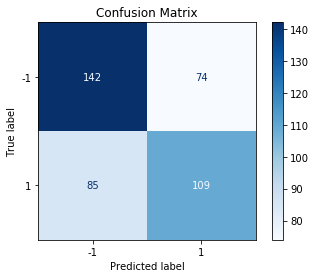

In [135]:
def rf_model(data, labels):
    #generate training data and split
    X = data.copy().drop(columns=['Raw_Labels','Smoothed_Labels','Raw_Return','Smoothed_Return'])
    y = labels.values.astype(int)
    
    split = int(len(X)*0.8)

    X_train = X[0:split]
    X_test = X[split+1:]
    
    y_train = y[0:split]
    y_test = y[split+1:]

    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)

    score = cross_val_score(rf,X_train,y_train)
    
    print("The cross validation score for Masterframe data is", rf.score(X_test,y_test))

    
    #Plot confusion matrices
    titles_options = [("Confusion matrix, without normalization", None)]

    disp = plot_confusion_matrix(rf, X_test, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues)

    disp.ax_.set_title("Confusion Matrix")
    
    return score
rf_model(df, df.Smoothed_Labels)

## 9.2 Evaluation Metrics

In [257]:
#Function used to split data
def get_split(df, train_size, scale, labeltype):
    
    #Split data for time series
    X = df.copy().drop(columns=['Raw_Labels','Raw_Return','Smoothed_Labels','Smoothed_Return'])

    if labeltype == "RAW":
        y = df.Raw_Labels
    else:
        y = df.Smoothed_Labels

    split = int(len(X)*train_size)

    X_train = X[:split]
    X_test = X[split+1:]

    #Scale data for better logistic regression model optimization
    scaler = StandardScaler()

    if scale:
    
        X_train = scaler.fit_transform(X_train)
        
        X_test = scaler.transform(X_test)

    y_train = y[:split]
    y_test = y[split+1:]

    #Return sets
    return X_train, X_test, y_train, y_test
    
#Function used to evaluate the financial viability of a model
def financial_report(predictions, returns):
    
    comb = pd.DataFrame(returns).reset_index()
    comb = comb.drop(columns=['Date'])

    #log returns graph
    tot = pd.DataFrame(predictions.values * comb.values)

    strategy = tot.cumsum().apply(np.exp)
    norm = comb.cumsum().apply(np.exp)

    roll_max = strategy.cummax()
    daily_drawdown = strategy/roll_max - 1
    max_daily_drawdown = daily_drawdown.cummin()
    md = np.min(max_daily_drawdown.to_numpy())

    cum_returns = pd.DataFrame(index=predictions.index, columns=['Returns'])

    total = 1000

    for i in range(0,len(predictions)):

        total += (predictions.iloc[i]*returns.iloc[i])*total

        cum_returns.iloc[i] = (total.values[0] - 1000)/1000

    cum_returns = cum_returns[cum_returns['Returns'] != 0]

    r = cum_returns.diff()

    r = r.replace([np.inf, -np.inf], np.nan)

    r = r.dropna()

    sr = r.mean()/r.std() * np.sqrt(252)

    ind = range(0,len(cum_returns))

    plot_backtest(norm, strategy)
    
    return sr, total, md 


#plotting cumulative returns backtest
def plot_backtest(norm, strategy):
    
    fig2, ax2 = plt.subplots(figsize=(15,7))

    ax2.grid(True)
    ax2.set_title("Model Cumulative Returns")
    ax2.set_ylabel("Returns")
    ax2.set_xlabel("Date")
    
    ax2.plot(norm, label='Buy-And-Hold')
    ax2.plot(strategy, label='Strategy')
    
    ax2.legend()
    

#General model evaluation report function
def model_report(df, model, X_train, y_train, X_test, y_test, val):

    og_columns = df.copy().drop(columns=['Raw_Labels','Raw_Return','Smoothed_Labels','Smoothed_Return']).columns
            
    fig, ax = plt.subplots(figsize=(5, 5))

    #get passed model
    clf = model

    #predict x_test
    pred = clf.predict(X_test)
    
    #print classification report
    print(classification_report(y_test, pred))
    
    #get f1 score for best model
    f1 = f1_score(y_test, pred, average='weighted')
    
    score = cross_val_score(clf,X_train,y_train)
    
    print("The Classification accuracy is:", clf.score(X_test,y_test))
    print("The cross validation score for Masterframe data is", score.mean())
    print("The F1-Score is:", f1)
    
    returns = df.Raw_Return.shift(-1)
    returns = returns.fillna(method='ffill')
    
    #Financial report
    sr, total, md = financial_report(pd.DataFrame(pred), returns[int(len(df)*0.8)+1:])
    
    if val:
        #Validation curve
        train_set, train_scores, val_scores = val_curve(X_train, y_train, X_test, y_test, clf)
        plot_val_curve(train_set, train_scores, val_scores)
    
    print()
    print("Model Results:")
    print("====================")
    
    print(f'The sharpes ratio of this model is: {sr.values[0]}')
    
    print(f'The Equity before backtest is: 1000')
    
    print(f'The Equity after backtest is: {total.values[0]}')
    
    print(f'The Maximum Drawdown is: {md}')
    
    print(f'The total return of model is: {(total.values[0] - 1000)/1000}')
    
    print()
    
    #draw confusion matrix
    disp = plot_confusion_matrix(clf, X_test, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues, ax=ax)
    disp.ax_.set_title("Confusion Matrix")

    plt.show()

In [258]:
#calculating and plotting validation curve
def val_curve(X_train, y_train, X_test, y_test, model):

    val_labels = y_test

    val = pd.DataFrame(X_test)

    X_train = pd.DataFrame(X_train)

    train_scores = []
    val_scores = []

    training_sets = np.linspace(50, len(X_train), 100, dtype='int')
    
    for i in training_sets:

        model.fit(X_train.iloc[0:i, :], y_train.iloc[0:i])

        pred = model.predict(X_train.iloc[0:i, :])

        train_acc = accuracy_score(y_train.iloc[0:i], pred)

        val_pred = model.predict(val)

        val_acc = accuracy_score(val_labels, val_pred)

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    return training_sets, train_scores, val_scores

#plotting validation curve
def plot_val_curve(training_sets, train_scores, val_scores):

    fig3, ax3 = plt.subplots(figsize=(15,7))
    ax3.clear()
    ax3.plot(training_sets, train_scores, c='gold', label='Training Error')
    ax3.plot(training_sets, val_scores, c='blue', label='Validation Error')

    ax3.set_title("Validation Curve")
    ax3.legend()

## 9.3 SMA-Crossover Strategy

In [259]:
def sma_cross_over(df):
    
    predictions = pd.DataFrame(columns=['Predictions'], index=df.index)
    
    for i in range(0, len(df)):
        
        if df.SMA15.iloc[i] >= df.SMA30.iloc[i]:
            
            predictions.iloc[i] = 1
            
        else:
            
            predictions.iloc[i] = -1
            
    return predictions

def get_sma_data():
    
    og = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")
    
    og['Date'] = pd.to_datetime(og.Date, format="%d.%m.%Y %H:%M:%S.%f")
    
    og['Date'] = pd.DataFrame(og.Date).applymap(lambda x: x.date()).astype(str)
    
    og = og.set_index(og.Date).drop(columns=['Date'])

    og['SMA15'] = ta.SMA(og.Close, timeperiod=15)
    
    og['SMA30'] = ta.SMA(og.Close, timeperiod=30)

    og = og.fillna(method='bfill')

    og = pd.merge(og, df, left_index=True, right_index=True)

    og = og[['Close','SMA15','SMA30']]
    
    return og

def evaluate_strategy(pred,returns,close):
  
    sr_random, total_random, md = financial_report(pred, returns)

    print(f'The sharpes ratio of SMA Crossover is: {sr_random.values[0]}')
    
    print(f'The Equity before backtest is: 1000')
    
    print(f'The Equity after backtest is: {total_random.values[0]}')
    
    print(f'The Maximum Drawdown is: {md}')
    
    print(f'The total return of SMA Crossover is: {(total_random.values[0] - 1000)/1000}')
    
    max_close = close.rolling(1)

The sharpes ratio of SMA Crossover is: -0.406199490375092
The Equity before backtest is: 1000
The Equity after backtest is: 717.9563342148701
The Maximum Drawdown is: -0.31308123725889736
The total return of SMA Crossover is: -0.28204366578512985


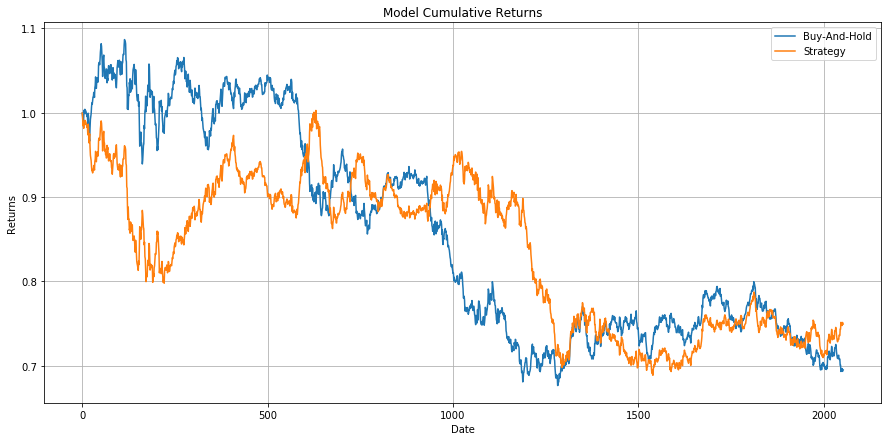

In [260]:
sma_data = get_sma_data()
pred = sma_cross_over(sma_data)
pred = pd.DataFrame(pred.Predictions).astype(int)
evaluate_strategy(pred,df.Raw_Return,sma_data.Close)

## 9.4 Decision Tree Classifier

In [261]:
#Function to optimize decision tree model
def decision_tree(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, False, labeltype)
    
    #Define RF model
    clf = DecisionTreeClassifier()
    
    #Define range of parameters to test and tune
    rf_params = {'criterion': ['gini','entropy'],
                 'splitter': ['best','random'],
                 'max_depth': [100,300,500,700,1000],
                 'min_samples_split': [2,4,6,8,10],
                 'class_weight': ['','balanced']}
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, rf_params, cv=cv_splits, n_jobs=-1, scoring='accuracy', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
            
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 300, 'min_samples_split': 4, 'splitter': 'random'}
              precision    recall  f1-score   support

          -1       0.51      0.43      0.47       203
           1       0.52      0.60      0.56       207

    accuracy                           0.52       410
   macro avg       0.52      0.52      0.51       410
weighted avg       0.52      0.52      0.51       410

The Classification accuracy is: 0.5170731707317073
The cross validation score for Masterframe data is 0.4969141522722218
The F1-Score is: 0.5137379287272166

Model Results:
The sharpes ratio of this model is: 0.6000040672683835
The Equity before backtest is: 1000
The Equity after backtest is: 1086.6608684548369
The Maximum Drawdown is: -0.07589099384887643
The total return of model is: 0.08666086845483688



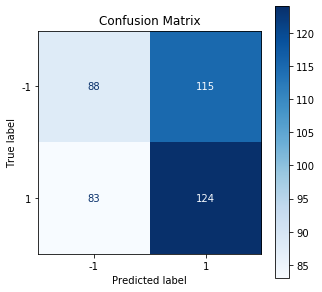

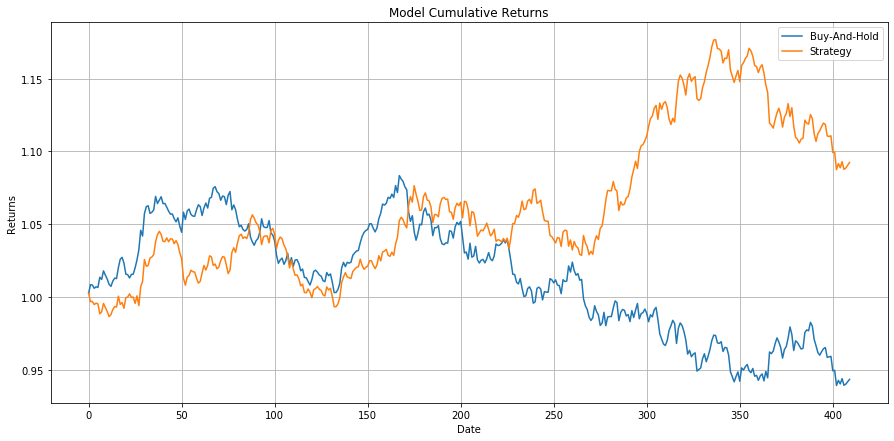

Wall time: 3.78 s


In [262]:
%%time
decision_tree_best_raw = decision_tree(df, "RAW", False)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 500, 'min_samples_split': 4, 'splitter': 'random'}
              precision    recall  f1-score   support

          -1       0.55      0.61      0.58       216
           1       0.50      0.43      0.46       194

    accuracy                           0.53       410
   macro avg       0.52      0.52      0.52       410
weighted avg       0.52      0.53      0.52       410

The Classification accuracy is: 0.526829268292683
The cross validation score for Masterframe data is 0.5480965972273705
The F1-Score is: 0.5232675594868569

Model Results:
The sharpes ratio of this model is: -1.2393665626295092
The Equity before backtest is: 1000
The Equity after backtest is: 854.6382510875081
The Maximum Drawdown is: -0.1575477946523146
The total return of model is: -0.14536174891249187



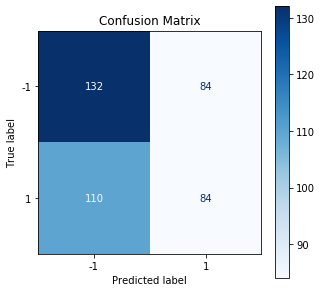

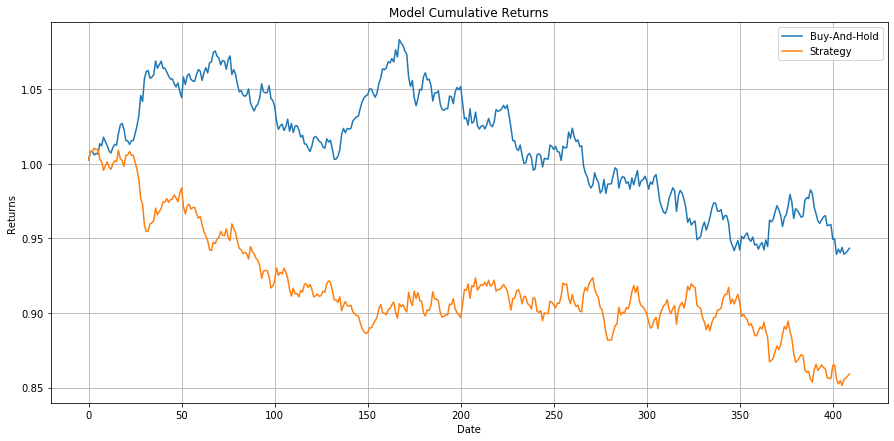

In [263]:
decision_tree_best_smoothed = decision_tree(df, "SMOOTHED", False)

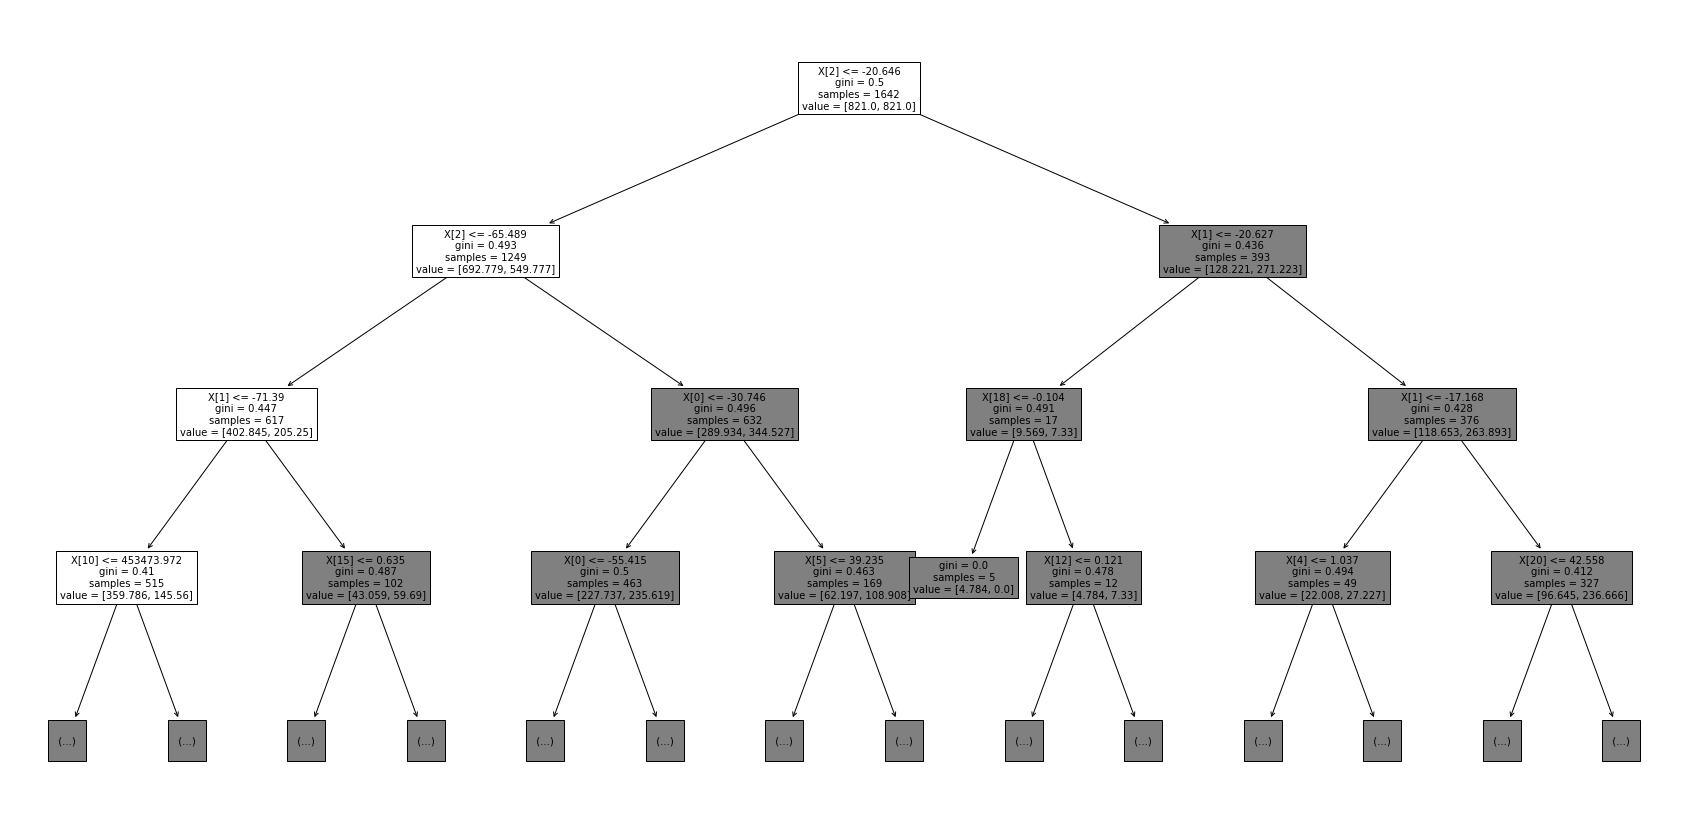

In [264]:
fig, ax = plt.subplots(figsize=(30,15))

tree.plot_tree(fontsize=10,max_depth=3,decision_tree=decision_tree_best,ax=ax);

## 9.5 Random Forrest Classifier

In [265]:
%%time
#Function to optimize random forest model
def random_forest_model(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, False, labeltype)
    
    #Define RF model
    clf = RandomForestClassifier(n_jobs=-1)
    
    #Define range of parameters to test and tune
    rf_params = {'n_estimators': [100, 200, 400, 600, 800, 1000],
                 'min_samples_split': [1,2,3,4,5]}
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, rf_params, cv=cv_splits, n_jobs=-1, scoring='roc_auc', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
        
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

Wall time: 0 ns


{'min_samples_split': 2, 'n_estimators': 600}
              precision    recall  f1-score   support

          -1       0.49      0.43      0.46       203
           1       0.50      0.57      0.53       207

    accuracy                           0.50       410
   macro avg       0.50      0.50      0.49       410
weighted avg       0.50      0.50      0.50       410

The Classification accuracy is: 0.4975609756097561
The cross validation score for Masterframe data is 0.48779931796278453
The F1-Score is: 0.4952170615007585

Model Results:
The sharpes ratio of this model is: 0.4172964913532119
The Equity before backtest is: 1000
The Equity after backtest is: 1059.5580729628962
The Maximum Drawdown is: -0.057806955819649786
The total return of model is: 0.059558072962896176



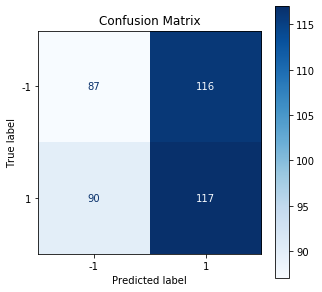

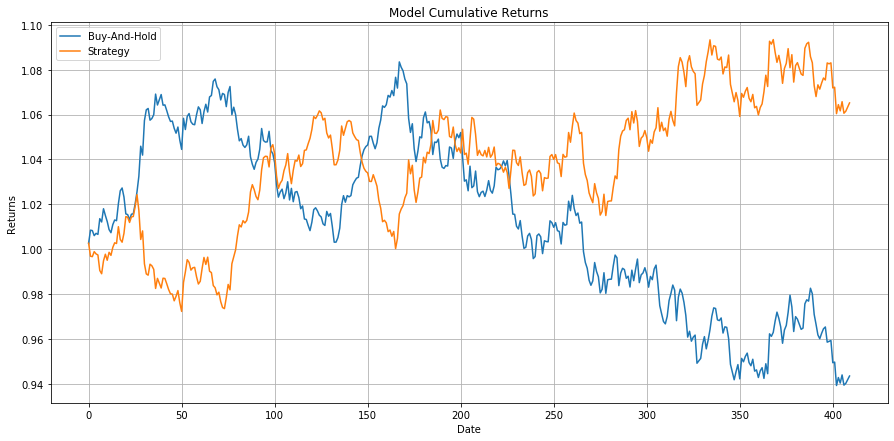

In [266]:
rf_best_raw = random_forest_model(df, "RAW", False)

{'min_samples_split': 4, 'n_estimators': 800}
              precision    recall  f1-score   support

          -1       0.65      0.68      0.66       216
           1       0.62      0.60      0.61       194

    accuracy                           0.64       410
   macro avg       0.64      0.64      0.64       410
weighted avg       0.64      0.64      0.64       410

The Classification accuracy is: 0.6390243902439025
The cross validation score for Masterframe data is 0.6047334865445919
The F1-Score is: 0.6385062434356401

Model Results:
The sharpes ratio of this model is: 0.3552615026015671
The Equity before backtest is: 1000
The Equity after backtest is: 1052.2277457982213
The Maximum Drawdown is: -0.09888613813568026
The total return of model is: 0.05222774579822135



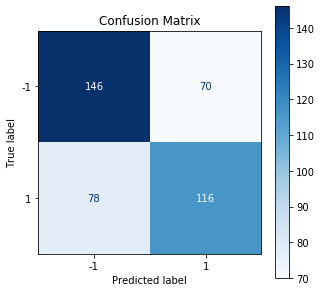

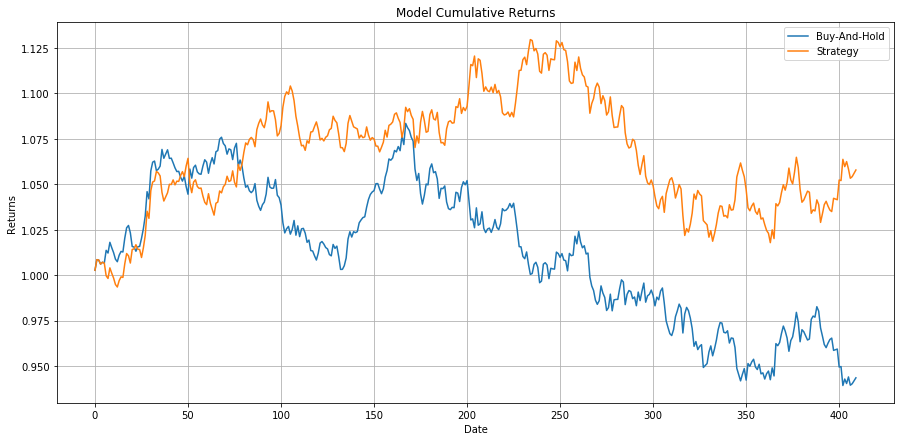

In [267]:
rf_best_smooth = random_forest_model(df, "SMOOTH", False)

## 9.6 SVM Model

In [268]:
%%time
#Function to optimize SVM model
def svm_model(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, True, labeltype)
    
    #generate list of params to test + optimize
    gamma_exp = [-15,-13,-11,-9,-7,-5,-3,-1,1,3]
    c_exp = [-5,-3,-1,1,3,5,7,9,11,13,15]

    gamma_list = []
    c_list = []

    for i in gamma_exp:
        gamma_list.append(2**i)

    for i in c_exp:
        c_list.append(2**i)

    svm_params = {'kernel': ['rbf'],
                  'C': c_list,
                  'gamma': gamma_list,
                  'class_weight': ['balanced']}
    
    #Define SVM model
    clf = SVC(probability=True)
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, svm_params, cv=cv_splits, n_jobs=-1, scoring='f1', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
        
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

Wall time: 0 ns


{'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf'}
              precision    recall  f1-score   support

          -1       0.17      0.00      0.01       203
           1       0.50      0.98      0.66       207

    accuracy                           0.50       410
   macro avg       0.33      0.49      0.34       410
weighted avg       0.33      0.50      0.34       410

The Classification accuracy is: 0.4951219512195122
The cross validation score for Masterframe data is 0.500604196011565
The F1-Score is: 0.33856899389360534

Model Results:
The sharpes ratio of this model is: -0.6738792463615273
The Equity before backtest is: 1000
The Equity after backtest is: 914.9340930064697
The Maximum Drawdown is: -0.14887767183337408
The total return of model is: -0.08506590699353035



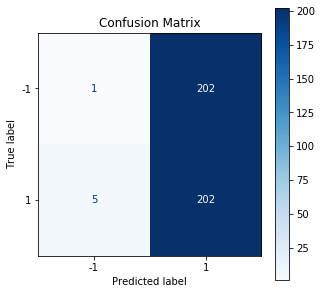

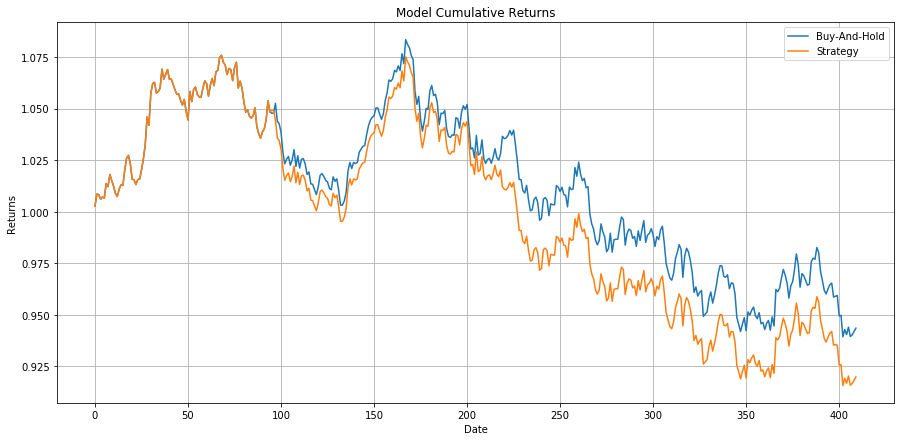

In [269]:
svm_best_raw = svm_model(df, "RAW", False)

{'C': 32, 'class_weight': 'balanced', 'gamma': 0.001953125, 'kernel': 'rbf'}
              precision    recall  f1-score   support

          -1       0.68      0.59      0.63       216
           1       0.60      0.70      0.65       194

    accuracy                           0.64       410
   macro avg       0.64      0.64      0.64       410
weighted avg       0.64      0.64      0.64       410

The Classification accuracy is: 0.6390243902439025
The cross validation score for Masterframe data is 0.6400678330491512
The F1-Score is: 0.6385088212804573

Model Results:
The sharpes ratio of this model is: 0.21413029798061256
The Equity before backtest is: 1000
The Equity after backtest is: 1032.4522915134728
The Maximum Drawdown is: -0.10880971225000136
The total return of model is: 0.0324522915134728



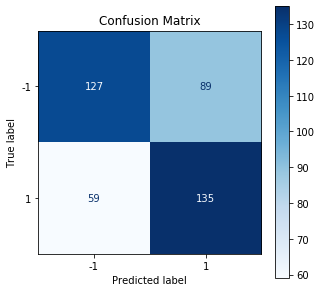

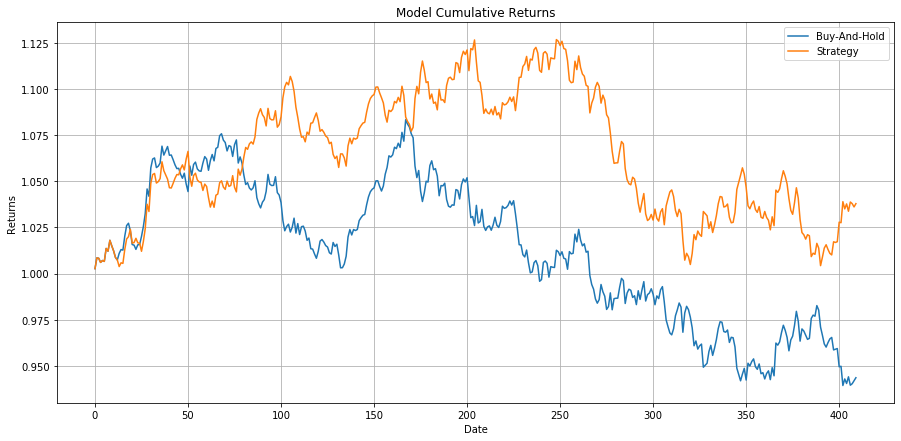

In [270]:
svm_best_smooth = svm_model(df, "SMOOTHED", False)

## 9.7 K-NN Classifier

In [271]:
%%time
#Function to optimize KNN model
def KNN_model(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, True, labeltype)
    
    #generate list of params to test + optimize
    n_neighbours_list = []

    weights_list = ['uniform','distance']

    metric_list = ['euclidean','manhattan','minkowski','chebyshev']
    
    algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']

    for i in range(5,int(np.sqrt(len(df)))+1,2):
    
        n_neighbours_list.append(i)

    knn_params = {'n_neighbors': n_neighbours_list,
                  'weights': weights_list,
                  'metric': metric_list,
                  'algorithm': algorithm_list}
    
    #Define KNN model
    clf = KNeighborsClassifier()
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, knn_params, cv=cv_splits, scoring='f1', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
        
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

Wall time: 0 ns


{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 7, 'weights': 'uniform'}
              precision    recall  f1-score   support

          -1       0.49      0.53      0.51       203
           1       0.50      0.46      0.48       207

    accuracy                           0.50       410
   macro avg       0.50      0.50      0.49       410
weighted avg       0.50      0.50      0.49       410

The Classification accuracy is: 0.4951219512195122
The cross validation score for Masterframe data is 0.4933019497368226
The F1-Score is: 0.4944575232771996

Model Results:
The sharpes ratio of this model is: -0.0754633463237912
The Equity before backtest is: 1000
The Equity after backtest is: 993.0585022133009
The Maximum Drawdown is: -0.12008792670035451
The total return of model is: -0.0069414977866990735



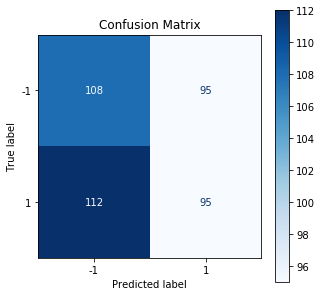

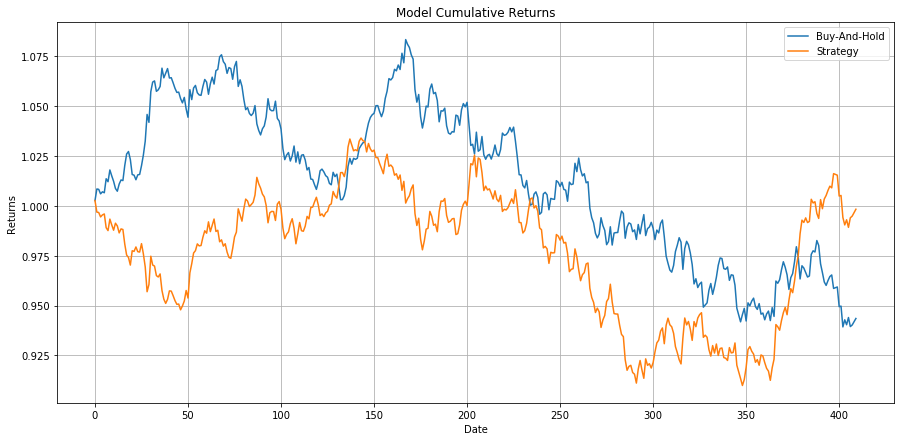

In [272]:
knn_best_raw = KNN_model(df, "RAW", False)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
              precision    recall  f1-score   support

          -1       0.60      0.73      0.66       216
           1       0.60      0.46      0.52       194

    accuracy                           0.60       410
   macro avg       0.60      0.60      0.59       410
weighted avg       0.60      0.60      0.60       410

The Classification accuracy is: 0.6024390243902439
The cross validation score for Masterframe data is 0.63095855882571
The F1-Score is: 0.5951128278541711

Model Results:
The sharpes ratio of this model is: 0.2974968633670974
The Equity before backtest is: 1000
The Equity after backtest is: 1043.4003232355556
The Maximum Drawdown is: -0.09132423340558504
The total return of model is: 0.04340032323555556



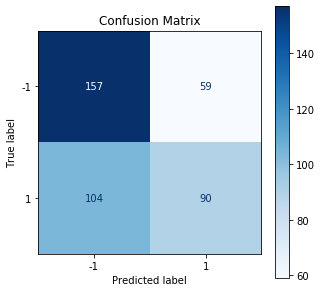

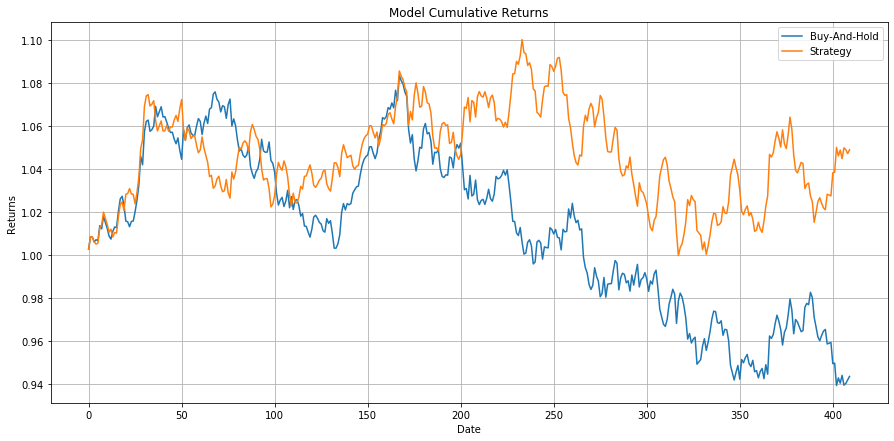

In [273]:
knn_best_smoothed = KNN_model(df, "SMOOTHED", False)

## 9.8 AdaBoost Model

In [274]:
%%time
#Function to optimize Adaboost model
def adaboost_model(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, False, labeltype)
    
    base_est_list = []
    
    for i in range(1,21):
        
        base_est_list.append(DecisionTreeClassifier(max_depth=i))
    
    adboost_params = {'n_estimators': [50, 100, 200, 400, 500],
                      'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                      'base_estimator': base_est_list}
    
    #Define Adaboost model
    clf = AdaBoostClassifier()
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, adboost_params, cv=cv_splits, n_jobs=-1, scoring='f1', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
        
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

Wall time: 0 ns


{'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.8, 'n_estimators': 50}
              precision    recall  f1-score   support

          -1       0.55      0.46      0.50       203
           1       0.54      0.63      0.58       207

    accuracy                           0.55       410
   macro avg       0.55      0.55      0.54       410
weighted avg       0.55      0.55      0.54       410

The Classification accuracy is: 0.5463414634146342
The cross validation score for Masterframe data is 0.5164207873081772
The F1-Score is: 0.5432083572892034

Model Results:
The sharpes ratio of this model is: 1.5426579277180885
The Equity before backtest is: 1000
The Equity after backtest is: 1221.749805487306
The Maximum Drawdown is: -0.05531240996268871
The total return of model is: 0.22174980548730605



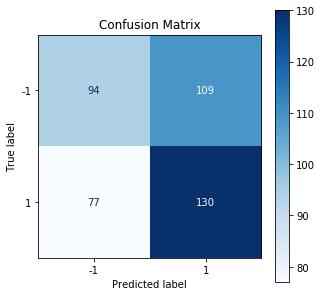

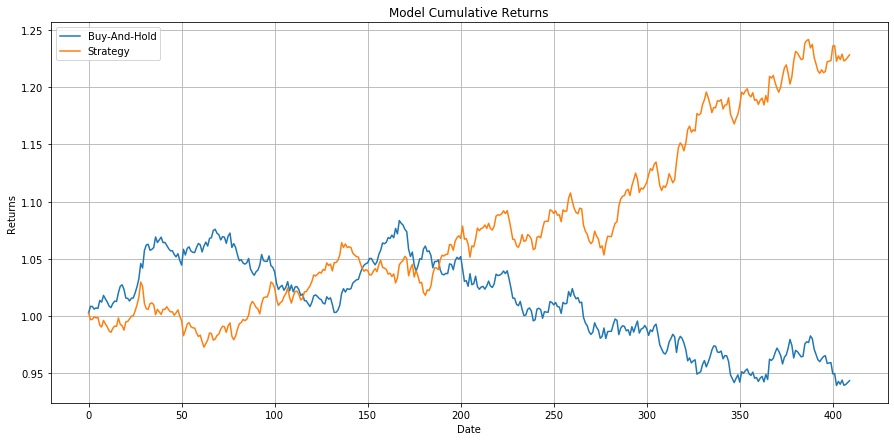

In [275]:
ada_best_raw = adaboost_model(df, "RAW", False)

{'base_estimator': DecisionTreeClassifier(max_depth=6), 'learning_rate': 0.8, 'n_estimators': 400}
              precision    recall  f1-score   support

          -1       0.59      0.66      0.62       216
           1       0.56      0.48      0.52       194

    accuracy                           0.58       410
   macro avg       0.57      0.57      0.57       410
weighted avg       0.57      0.58      0.57       410

The Classification accuracy is: 0.5756097560975609
The cross validation score for Masterframe data is 0.6120598265253169
The F1-Score is: 0.5724152337665623

Model Results:
The sharpes ratio of this model is: -0.24827349177943026
The Equity before backtest is: 1000
The Equity after backtest is: 969.8754730972257
The Maximum Drawdown is: -0.14712212666442814
The total return of model is: -0.030124526902774278



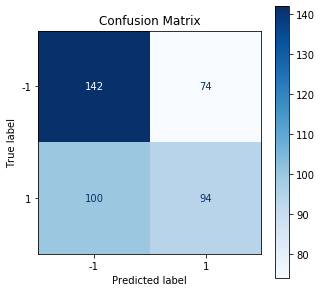

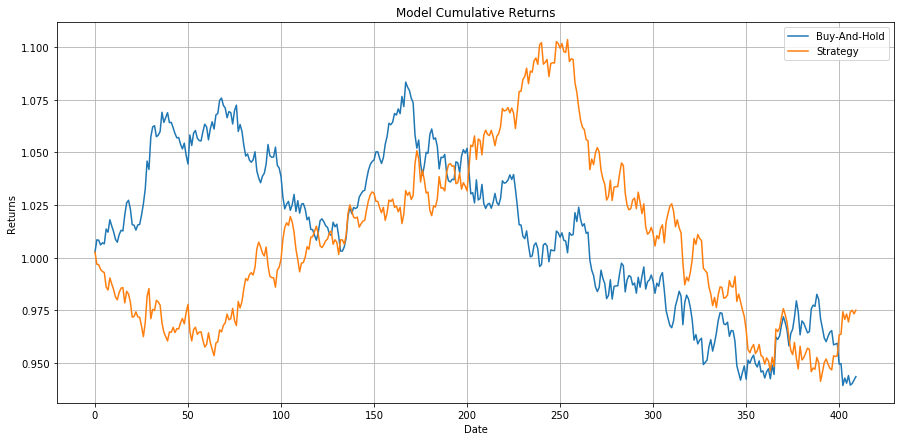

In [276]:
ada_best_smoothed = adaboost_model(df, "SMOOTHED", False)

## 9.9 Logistic Regression Model

In [277]:
%%time
#Function to optimize Logistic Regression model
def logistic_regression_model(df, labeltype, val):   
    #Split data
    X_train, X_test, y_train, y_test = get_split(df, 0.8, True, labeltype)
    
    c_exp = [-5,-3,-1,1,3,5,7,9,11,13,15]

    c_list = []

    for i in c_exp:
        c_list.append(2**i)
    
    lr_params = {'max_iter': [100, 200, 400, 600, 800, 1000],
                 'class_weight': ['balanced','None'],
                 'C': c_list}
    
    #Define Logistic Regression model
    clf = LogisticRegression(n_jobs=-1)
    
    #Define cross validation splits (using 3 due to lack of data)
    cv_splits = TimeSeriesSplit(n_splits=5).split(X_train)
    
    #run grid search
    grid = GridSearchCV(clf, lr_params, cv=cv_splits, n_jobs=-1, scoring='f1', refit=True)
        
    #fit grid model
    grid.fit(X_train, y_train)
    
    #get best model from grid search
    best_model = grid.best_estimator_
    
    #output best parameters
    print(grid.best_params_)
        
    model_report(df, best_model, X_train, y_train, X_test, y_test, val)
    
    return best_model

Wall time: 0 ns


{'C': 32, 'class_weight': 'balanced', 'max_iter': 200}
              precision    recall  f1-score   support

          -1       0.52      0.59      0.55       203
           1       0.53      0.46      0.50       207

    accuracy                           0.52       410
   macro avg       0.53      0.52      0.52       410
weighted avg       0.53      0.52      0.52       410

The Classification accuracy is: 0.524390243902439
The cross validation score for Masterframe data is 0.5134127807843429
The F1-Score is: 0.5226276855926086

Model Results:
The sharpes ratio of this model is: 0.962965419076274
The Equity before backtest is: 1000
The Equity after backtest is: 1130.512776943032
The Maximum Drawdown is: -0.08741203202641834
The total return of model is: 0.1305127769430319



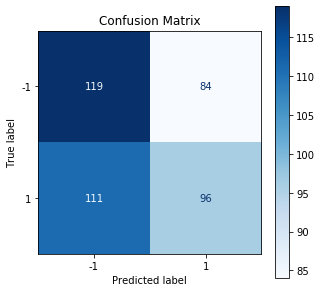

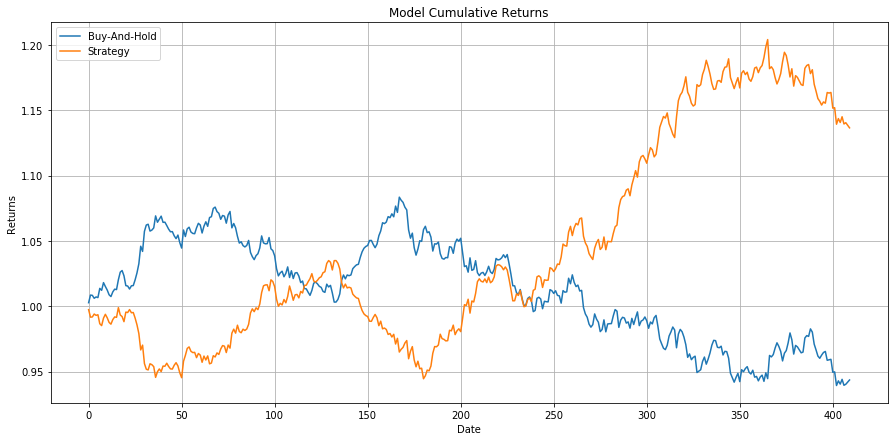

In [278]:
lr_best_raw = logistic_regression_model(df, "RAW", False)

{'C': 128, 'class_weight': 'balanced', 'max_iter': 100}
              precision    recall  f1-score   support

          -1       0.67      0.63      0.65       216
           1       0.62      0.65      0.64       194

    accuracy                           0.64       410
   macro avg       0.64      0.64      0.64       410
weighted avg       0.65      0.64      0.64       410

The Classification accuracy is: 0.6439024390243903
The cross validation score for Masterframe data is 0.6413003187782638
The F1-Score is: 0.644156794425087

Model Results:
The sharpes ratio of this model is: 0.04072008461691303
The Equity before backtest is: 1000
The Equity after backtest is: 1008.2044941400139
The Maximum Drawdown is: -0.10264579868445955
The total return of model is: 0.008204494140013936



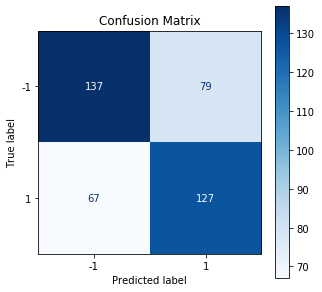

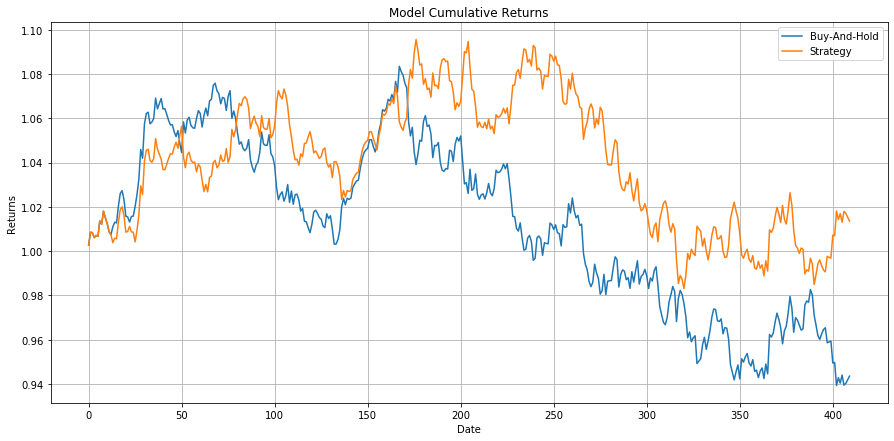

In [279]:
lr_best_smoothed = logistic_regression_model(df, "SMOOTHED", False)

## 9.10 Voting (Ensemble) Classifier

In [280]:
def voting_classifier(df, est_list, labeltype, val):
    
    X_train, X_test, y_train, y_test = get_split(df, 0.8, True, labeltype)
    
    #intialise soft VC model
    vot_soft = VotingClassifier(estimators=est_list, voting='soft', n_jobs=-1)
    
    #fit soft vc model and generate predictions
    vot_soft.fit(X_train, y_train)
    
    soft_pred = vot_soft.predict(X_test)
    
    #intialise hard VC model
    vot_hard = VotingClassifier(estimators=est_list, voting='hard', n_jobs=-1)
    
    #fit hard vc model and generate predictions
    vot_hard.fit(X_train, y_train)
    
    hard_pred = vot_hard.predict(X_test)
    
    #Visualise results from backtest and cross validation
    print("Results for Soft VC:")
    print("######################")
    
    print()
    
    print("Accuracy of Soft Voting Classifier:", accuracy_score(y_test, soft_pred))
    
    model_report(df, vot_soft, X_train, y_train, X_test, y_test, val)
    
    print()
    
    print("Results for Hard VC:")
    print("######################")
    
    print()
    
    print("Accuracy of Hard Voting Classifier:", accuracy_score(y_test, hard_pred))
    
    model_report(df, vot_hard, X_train, y_train, X_test, y_test, val)
    
    return vot_hard

Results for Soft VC:
######################

Accuracy of Soft Voting Classifier: 0.5292682926829269
              precision    recall  f1-score   support

          -1       0.52      0.58      0.55       203
           1       0.54      0.48      0.51       207

    accuracy                           0.53       410
   macro avg       0.53      0.53      0.53       410
weighted avg       0.53      0.53      0.53       410

The Classification accuracy is: 0.5292682926829269
The cross validation score for Masterframe data is 0.5085106382978724
The F1-Score is: 0.528041924598596

Model Results:
The sharpes ratio of this model is: 1.300490586502292
The Equity before backtest is: 1000
The Equity after backtest is: 1176.5979754892517
The Maximum Drawdown is: -0.08144658332551002
The total return of model is: 0.17659797548925166



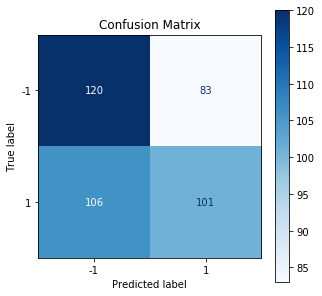

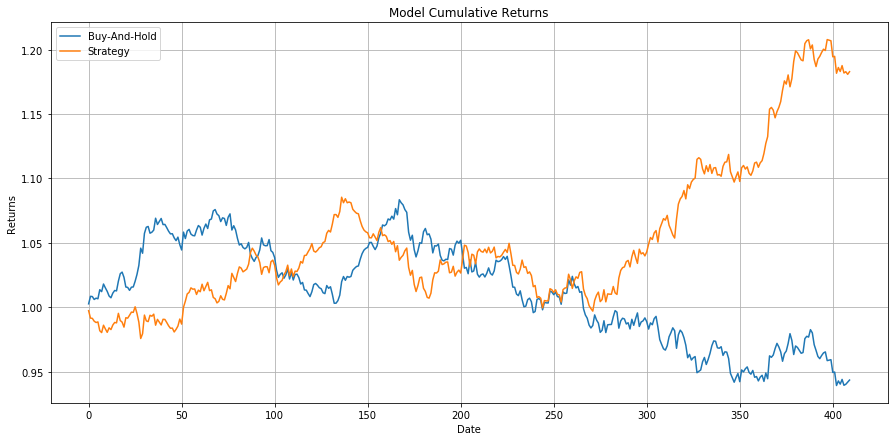

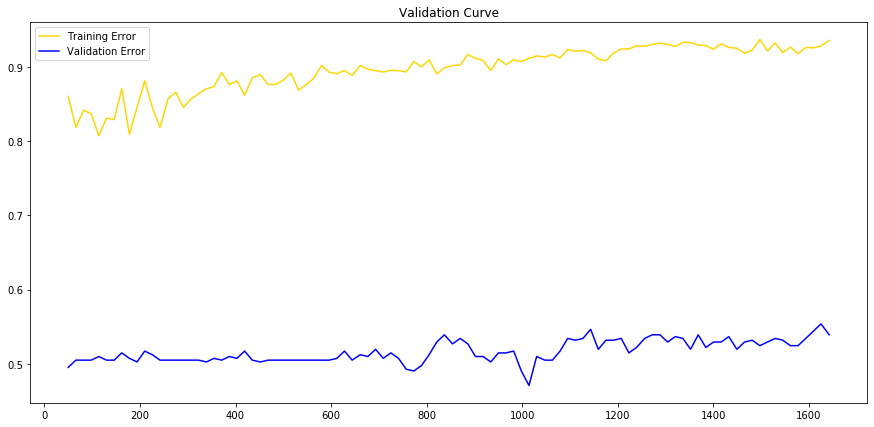


Results for Hard VC:
######################

Accuracy of Hard Voting Classifier: 0.5
              precision    recall  f1-score   support

          -1       0.49      0.45      0.47       203
           1       0.50      0.55      0.52       207

    accuracy                           0.50       410
   macro avg       0.50      0.50      0.50       410
weighted avg       0.50      0.50      0.50       410

The Classification accuracy is: 0.5
The cross validation score for Masterframe data is 0.5091407813774187
The F1-Score is: 0.4989353389916437

Model Results:
The sharpes ratio of this model is: 0.598607102413696
The Equity before backtest is: 1000
The Equity after backtest is: 1082.842691580741
The Maximum Drawdown is: -0.07873470905737101
The total return of model is: 0.08284269158074108



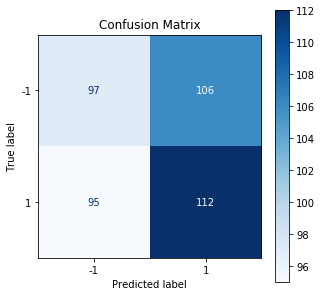

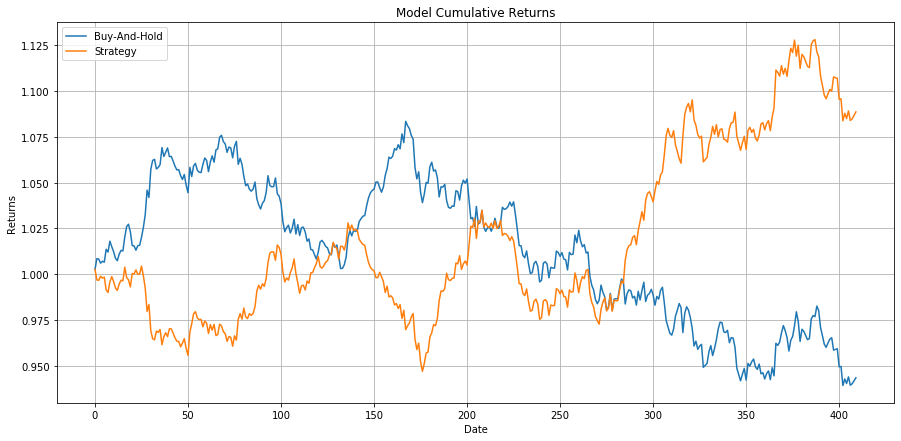

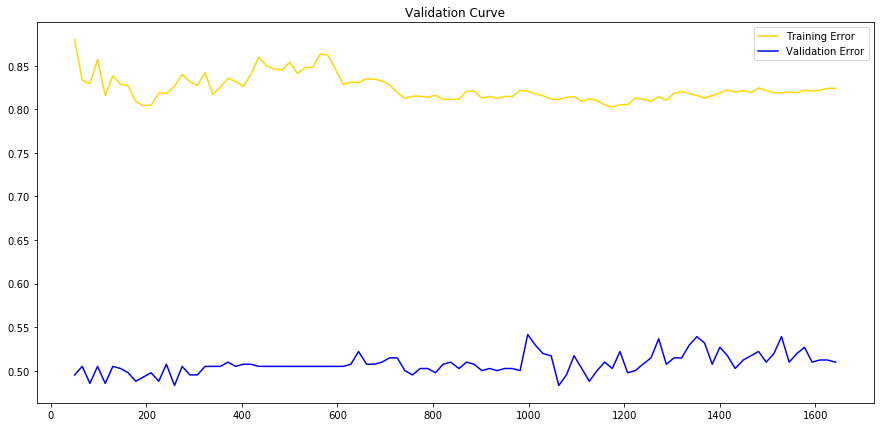

In [281]:
est_list = [('lr', lr_best_raw),('svm', svm_best_raw),('rf', rf_best_raw),('knn', knn_best_raw),('ada', lr_best_raw)]

vc_best = voting_classifier(df, est_list, "RAW", True)

Results for Soft VC:
######################

Accuracy of Soft Voting Classifier: 0.6414634146341464
              precision    recall  f1-score   support

          -1       0.67      0.64      0.65       216
           1       0.62      0.64      0.63       194

    accuracy                           0.64       410
   macro avg       0.64      0.64      0.64       410
weighted avg       0.64      0.64      0.64       410

The Classification accuracy is: 0.6414634146341464
The cross validation score for Masterframe data is 0.6424938839054044
The F1-Score is: 0.6416876668543305

Model Results:
The sharpes ratio of this model is: -0.23917257217673657
The Equity before backtest is: 1000
The Equity after backtest is: 970.3060270134191
The Maximum Drawdown is: -0.1350299779427665
The total return of model is: -0.02969397298658089



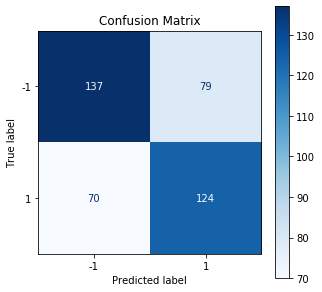

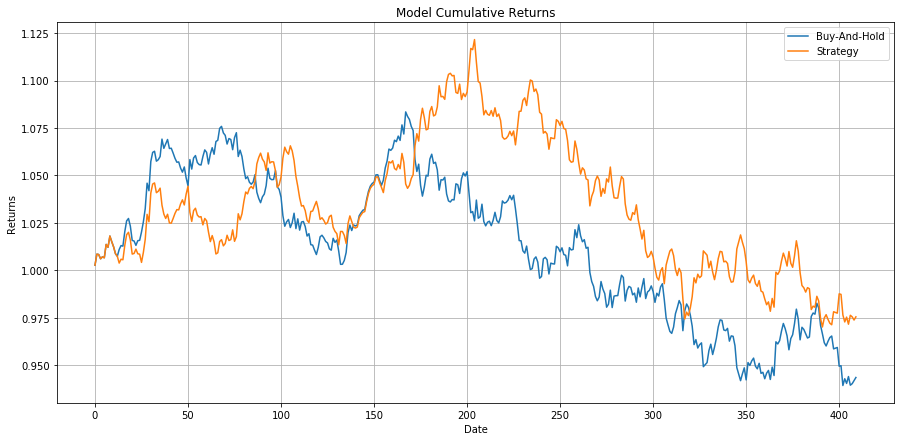

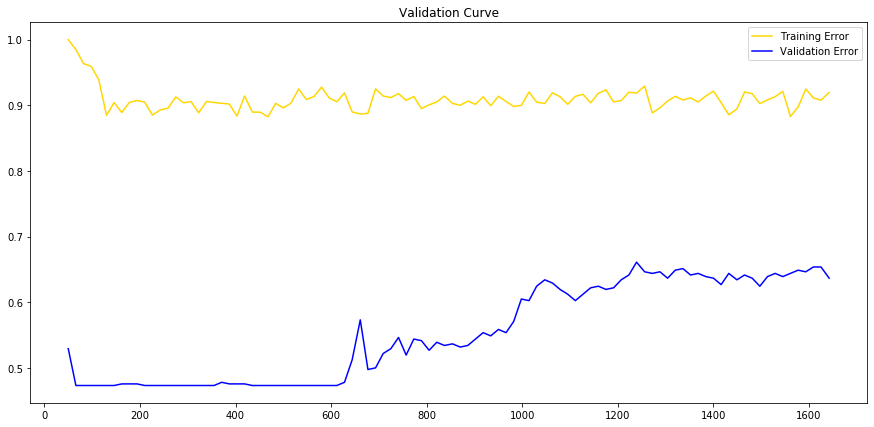


Results for Hard VC:
######################

Accuracy of Hard Voting Classifier: 0.6463414634146342
              precision    recall  f1-score   support

          -1       0.68      0.63      0.65       216
           1       0.62      0.66      0.64       194

    accuracy                           0.65       410
   macro avg       0.65      0.65      0.65       410
weighted avg       0.65      0.65      0.65       410

The Classification accuracy is: 0.6463414634146342
The cross validation score for Masterframe data is 0.6418841278078433
The F1-Score is: 0.6465624329199716

Model Results:
The sharpes ratio of this model is: 0.17857340523041523
The Equity before backtest is: 1000
The Equity after backtest is: 1027.1483663450842
The Maximum Drawdown is: -0.12022173314311468
The total return of model is: 0.027148366345084243



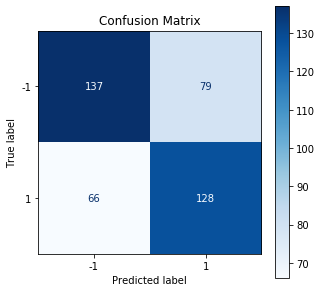

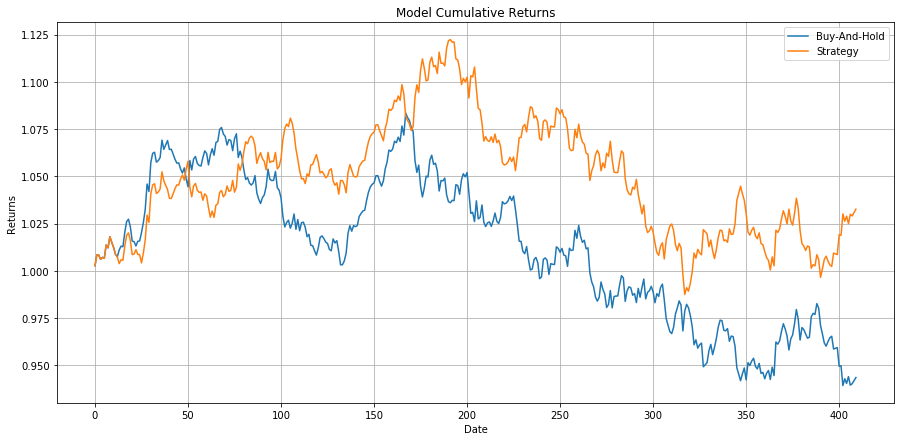

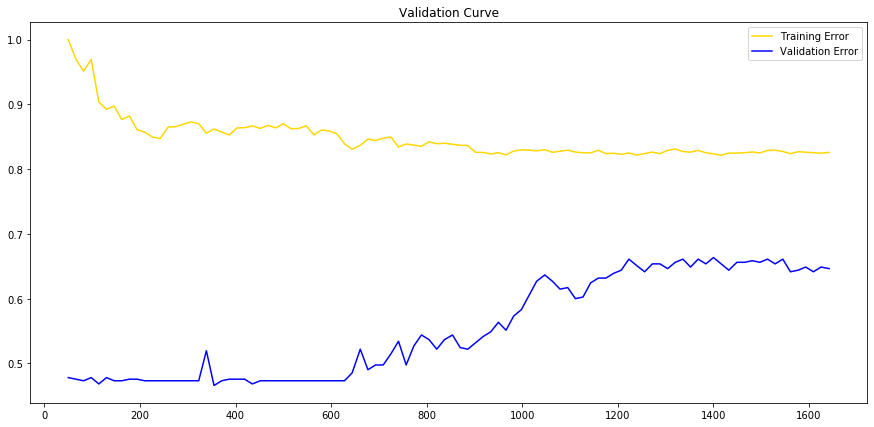

In [282]:
vc_best_smoothed = voting_classifier(df, est_list, "SMOOTH", True)